In [2]:
import sqlite3
from pathlib import Path
import pandas as pd
import logging
import shutil
import cv2
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Function to calculate metrics
def calculate_metrics(df, group_name, true_type):
    """
    Calculate and print various metrics for the given DataFrame.
    
    Parameters:
    ----------
    df (pd.DataFrame): 
        DataFrame containing the data to calculate metrics on.
    group_name (str):
        Name of the group for which metrics are calculated.
    true_type (str):
        Combined or individual type.
    """
    if true_type == 'combined':
        # Filter out rows with NaN values in 'proximity_true' or 'proximity_heuristic'
        true_values = df['proximity_true']
    elif true_type == 'lotta':
        true_values = df['proximity_true_lotta']
    elif true_type == 'clara':
        true_values = df['proximity_true_clara']
    else:
        raise ValueError("Invalid true_type. Must be 'combined', 'lotta', or 'clara'.")

    predicted_values = df['proximity_heuristic']
    
    # Pearson Correlation
    pearson_corr = true_values.corr(predicted_values)
    
    # Spearman Correlation
    spearman_corr = true_values.corr(predicted_values, method='spearman')
    
    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(true_values, predicted_values)
    
    # RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    
    # R-squared
    ss_total = ((true_values - true_values.mean()) ** 2).sum()
    ss_residual = ((true_values - predicted_values) ** 2).sum()
    r_squared = 1 - (ss_residual / ss_total)
    
    # Bias
    bias = (predicted_values - true_values).mean()
    
    print(f"Metrics for {group_name}:")
    print(f"  Pearson Correlation: {pearson_corr}")
    print(f"  Spearman Correlation: {spearman_corr}")
    print(f"  MAE: {mae}")
    print(f"  RMSE: {rmse}")
    print(f"  R-squared: {r_squared}")
    print(f"  Bias: {bias}")
    print()

## Correlate the heuristic and average estimation

In [3]:
import pandas as pd
# read xlsx file with proximity values
# load xlsx file
import pandas as pd
proximity_df_adult = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name="adult_final")
proximity_df_child = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name='child_final')

proximity_df_adult['age_group'] = 'adult'
proximity_df_child['age_group'] = 'child'

# combine both dataframes
proximity_df = pd.concat([proximity_df_adult, proximity_df_child], ignore_index=True)
# remove duplicates based on column frame_file_name
proximity_df = proximity_df.drop_duplicates(subset=['frame_file_name'])

# remove the first four values of the frame_file_name column
proximity_df['frame_file_name'] = proximity_df['frame_file_name'].str[4:]

# load csv with proximity heuristic values from csv as dataframe
proximity_df_heuristic = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_results.csv')[['frame_file_name', 'proximity']]

# remove the first four values of the frame_file_name column
proximity_df_heuristic['frame_file_name'] = proximity_df_heuristic['frame_file_name'].str[4:]
# drop duplicates based on column frame_file_name
proximity_df_heuristic = proximity_df_heuristic.drop_duplicates(subset=['frame_file_name'])

# now add the proximity values from the heuristic dataframe to the proximity_df dataframe
proximity_eval_df = proximity_df.merge(proximity_df_heuristic, on='frame_file_name', how='left')
proximity_eval_df = proximity_eval_df.rename(columns={'frame_file_name': 'frame', 'proximity_mean': 'proximity_true', 'proximity': 'proximity_heuristic'})
# change column order
proximity_eval_df = proximity_eval_df[['frame', 'proximity_true', 'proximity_heuristic', 'age_group']]
proximity_eval_df_clean = proximity_eval_df.dropna(subset=['proximity_heuristic'])
# drop duplicates based on column frame_file_name
proximity_eval_df_clean = proximity_eval_df_clean.drop_duplicates(subset=['frame'])
proximity_eval_df_clean.head()

,frame,proximity_true,proximity_heuristic,age_group
0,quantex_at_home_id260123_2023_09_06_01_013290.jpg,0.595,0.748534,adult
1,quantex_at_home_id262726_2023_04_15_02_044930.jpg,0.415,0.578474,adult
2,quantex_at_home_id260176_2022_11_06_02_048600.jpg,0.055,0.091071,adult
3,quantex_at_home_id257608_2021_12_20_02_017230.jpg,0.695,0.742360,adult
4,quantex_at_home_id260275_2022_04_16_01_011640.jpg,0.235,0.352604,adult


Metrics for Combined:
  Pearson Correlation: 0.94917482835671
  Spearman Correlation: 0.9536136542308579
  MAE: 0.09136410365257194
  RMSE: 0.1110640173082633
  R-squared: 0.8402584796946171
  Bias: 0.0682149322339738

Metrics for Adults:
  Pearson Correlation: 0.9548376172407473
  Spearman Correlation: 0.9541190251100976
  MAE: 0.10152614853557129
  RMSE: 0.12073896588785395
  R-squared: 0.8207163611577188
  Bias: 0.08595289675658961

Metrics for Children:
  Pearson Correlation: 0.9371762414624066
  Spearman Correlation: 0.9390695901584399
  MAE: 0.08086143156679047
  RMSE: 0.10008676386624782
  R-squared: 0.8380789556521092
  Bias: 0.049882399068141806



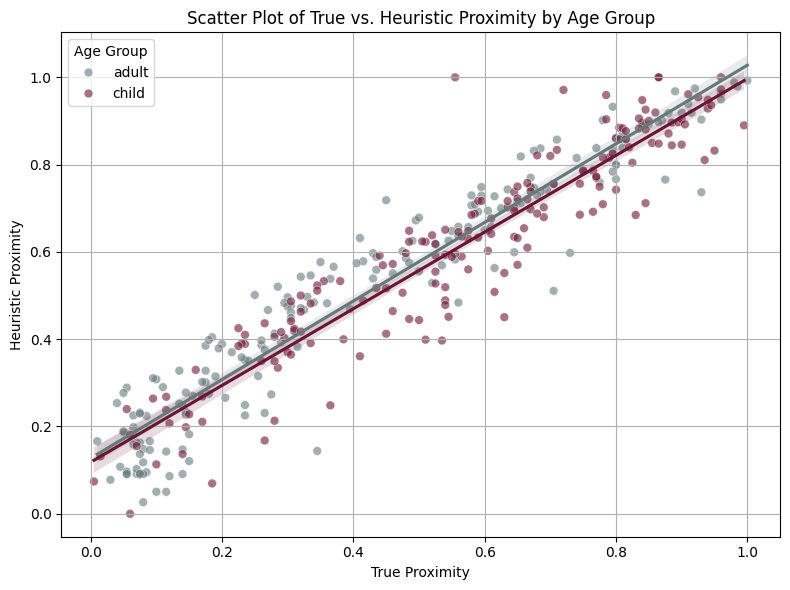

In [4]:
# Combined metrics
calculate_metrics(proximity_eval_df_clean, "Combined", "combined")

# Metrics for adults
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'], "Adults", "combined")

# Metrics for children
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'], "Children", "combined")

# Visualize with regression line and color by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='proximity_true',
    y='proximity_heuristic',
    hue='age_group',  # Color points by age group
    palette={'adult': '#66787C', 'child': '#691633'},  # Custom colors in hex format
    data=proximity_eval_df_clean,
    alpha=0.6,  # Transparency for points
    s=40  # Size of points
)

# Add regression lines for each group
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'],
    scatter=False,
    color='#66787C',  # Match adult color
)
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'],
    scatter=False,
    color='#691633',  # Match child color
)

# Add plot labels and legend
plt.title('Scatter Plot of True vs. Heuristic Proximity by Age Group')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.legend(title='Age Group')
plt.grid(True)
plt.tight_layout()
plt.savefig('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_eval_plot.png', dpi=600)
plt.show()

Pearson Correlation: 0.94917482835671
Spearman Correlation: 0.9536136542308579


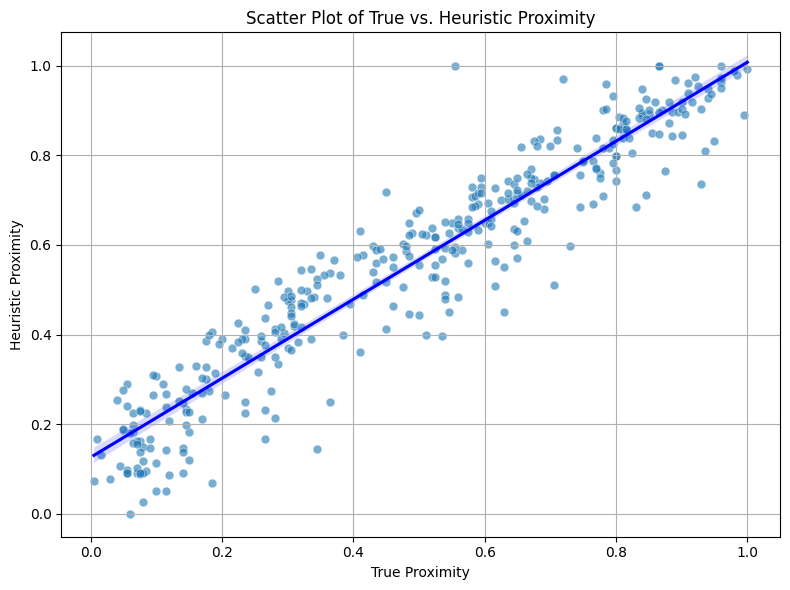

In [5]:
# Calculate Pearson Correlation Coefficient

pearson_corr = proximity_eval_df_clean['proximity_true'].corr(proximity_eval_df_clean['proximity_heuristic'])
print(f"Pearson Correlation: {pearson_corr}")

# Calculate Spearman Rank Correlation
spearman_corr = proximity_eval_df_clean['proximity_true'].corr(proximity_eval_df_clean['proximity_heuristic'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

# Visualize with regression line and color by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    alpha=0.6,  # Transparency for points
    s=40  # Size of points
)

# Add regression lines for each group
sns.regplot(
    x='proximity_true',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    scatter=False,
    color='blue',
    label='Regression Line'
)

# Add plot labels and legend
plt.title('Scatter Plot of True vs. Heuristic Proximity')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# define absolute difference betewen the two proximity values and sort the dataframe by this value
proximity_eval_df_clean['absolute_difference'] = abs(proximity_eval_df_clean['proximity_true'] - proximity_eval_df_clean['proximity_heuristic'])
proximity_eval_df_clean = proximity_eval_df_clean.sort_values(by='absolute_difference', ascending=False)
proximity_eval_df_clean[proximity_eval_df_clean['absolute_difference'] > 0.2]

,frame,proximity_true,proximity_heuristic,age_group,absolute_difference
266,quantex_at_home_id261609_2022_04_01_06_008910.jpg,0.555,1.000000,child,0.445000
191,quantex_at_home_id265514_2024_09_04_01_025970.jpg,0.450,0.718422,adult,0.268422
121,quantex_at_home_id258704_2022_05_17_03_024650.jpg,0.250,0.501313,adult,0.251313
200,quantex_at_home_id268898_2022_11_30_01_043160.jpg,0.720,0.970965,child,0.250965
158,quantex_at_home_id263986_2022_11_29_01_027730.jpg,0.285,0.520245,adult,0.235245
18,quantex_at_home_id254922_2022_06_29_01_021030.jpg,0.055,0.288916,adult,0.233916
189,quantex_at_home_id260176_2022_11_06_02_044640.jpg,0.050,0.276862,adult,0.226862
96,quantex_at_home_id262726_2023_04_20_01_037150.jpg,0.350,0.576759,adult,0.226759
139,quantex_at_home_id263293_2022_08_29_01_031530.jpg,0.320,0.543022,adult,0.223022
91,quantex_at_home_id264351_2024_11_23_03_010000.jpg,0.410,0.631738,adult,0.221738


In [7]:
len(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult']), len(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'])

(185, 179)

In [ ]:
total_len = len(proximity_eval_df_clean)
thresholds = [0.2, 0.15, 0.1]

for threshold in thresholds:
    below = len(proximity_eval_df_clean[proximity_eval_df_clean['absolute_difference'] <= threshold]) / total_len * 100
    print(f"From {total_len} frames, {below:.2f}% frames have an absolute difference below {threshold}.")

From 364 frames, 94.78% frames have an absolute difference below 0.2.
From 364 frames, 80.77% frames have an absolute difference below 0.15.
From 364 frames, 58.24% frames have an absolute difference below 0.1.


### Correlate the heuristic and Lottas estimation

In [13]:
# load xlsx file
import pandas as pd
proximity_df_adult = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name="adult_final")
proximity_df_child = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name='child_final')

proximity_df_adult['age_group'] = 'adult'
proximity_df_child['age_group'] = 'child'

# combine both dataframes
proximity_df = pd.concat([proximity_df_adult, proximity_df_child], ignore_index=True)
# remove duplicates based on column frame_file_name
proximity_df = proximity_df.drop_duplicates(subset=['frame_file_name'])

# remove the first four values of the frame_file_name column
proximity_df['frame_file_name'] = proximity_df['frame_file_name'].str[4:]

# load csv with proximity heuristic values from csv as dataframe
proximity_df_heuristic = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_results.csv')[['frame_file_name', 'proximity']]

# remove the first four values of the frame_file_name column
proximity_df_heuristic['frame_file_name'] = proximity_df_heuristic['frame_file_name'].str[4:]
# drop duplicates based on column frame_file_name
proximity_df_heuristic = proximity_df_heuristic.drop_duplicates(subset=['frame_file_name'])

# now add the proximity values from the heuristic dataframe to the proximity_df dataframe
proximity_eval_df = proximity_df.merge(proximity_df_heuristic, on='frame_file_name', how='left')
proximity_eval_df = proximity_eval_df.rename(columns={'frame_file_name': 'frame', 'proximity_lotta': 'proximity_true_lotta', 'proximity': 'proximity_heuristic'})
# change column order
proximity_eval_df = proximity_eval_df[['frame', 'proximity_true_lotta', 'proximity_heuristic', 'age_group']]
proximity_eval_df_clean = proximity_eval_df.dropna(subset=['proximity_heuristic'])
# drop duplicates based on column frame_file_name
proximity_eval_df_clean = proximity_eval_df_clean.drop_duplicates(subset=['frame'])


Metrics for Combined:
  Pearson Correlation: 0.9035109924273224
  Spearman Correlation: 0.926244332820442
  MAE: 0.1596393061397832
  RMSE: 0.18747300444229234
  R-squared: 0.45878964788730536
  Bias: 0.14980833882738037

Metrics for Adults:
  Pearson Correlation: 0.9077700954903025
  Spearman Correlation: 0.9216020079406579
  MAE: 0.15725915629440212
  RMSE: 0.18573324991597132
  R-squared: 0.49923864821873454
  Bias: 0.14641235621604912

Metrics for Children:
  Pearson Correlation: 0.8877388594951516
  Spearman Correlation: 0.9087087329756078
  MAE: 0.16209923754422736
  RMSE: 0.18925426939439463
  R-squared: 0.3518203101102909
  Bias: 0.15331815325808593



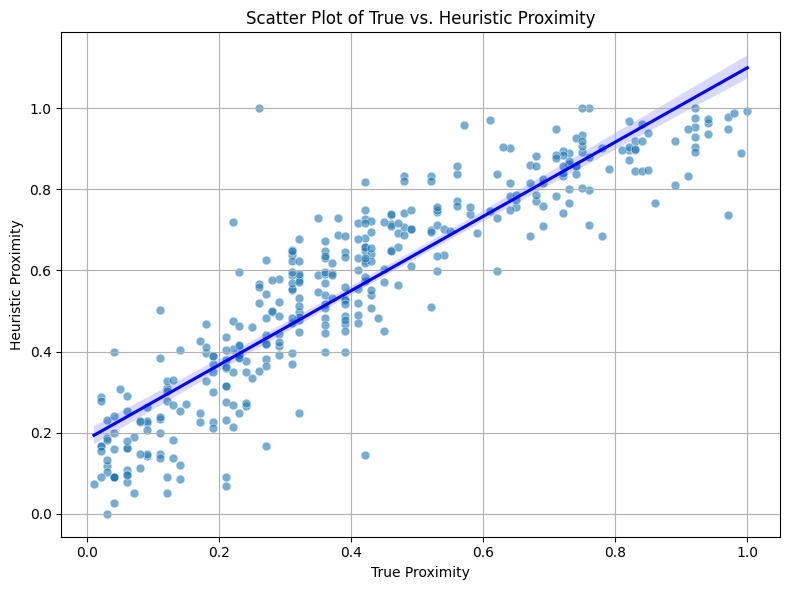

In [16]:
# Combined metrics
calculate_metrics(proximity_eval_df_clean, "Combined", "lotta")

# Metrics for adults
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'], "Adults", "lotta")

# Metrics for children
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'], "Children", "lotta")

# Visualize with regression line and color by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='proximity_true_lotta',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    alpha=0.6,  # Transparency for points
    s=40  # Size of points
)

# Add regression lines for each group
sns.regplot(
    x='proximity_true_lotta',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    scatter=False,
    color='blue',
    label='Regression Line'
)

# Add plot labels and legend
plt.title('Scatter Plot of True vs. Heuristic Proximity')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.grid(True)
plt.tight_layout()
plt.show()

### Correlate the heuristic and Claras estimation

In [17]:
import pandas as pd
# read xlsx file with proximity values
# load xlsx file
import pandas as pd
proximity_df_adult = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name="adult_final")
proximity_df_child = pd.read_excel('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_true_final.xlsx', sheet_name='child_final')

proximity_df_adult['age_group'] = 'adult'
proximity_df_child['age_group'] = 'child'

# combine both dataframes
proximity_df = pd.concat([proximity_df_adult, proximity_df_child], ignore_index=True)
# remove duplicates based on column frame_file_name
proximity_df = proximity_df.drop_duplicates(subset=['frame_file_name'])

# remove the first four values of the frame_file_name column
proximity_df['frame_file_name'] = proximity_df['frame_file_name'].str[4:]

# load csv with proximity heuristic values from csv as dataframe
proximity_df_heuristic = pd.read_csv('/home/nele_pauline_suffo/ProcessedData/proximity_heuristic/proximity_results.csv')[['frame_file_name', 'proximity']]

# remove the first four values of the frame_file_name column
proximity_df_heuristic['frame_file_name'] = proximity_df_heuristic['frame_file_name'].str[4:]
# drop duplicates based on column frame_file_name
proximity_df_heuristic = proximity_df_heuristic.drop_duplicates(subset=['frame_file_name'])

# now add the proximity values from the heuristic dataframe to the proximity_df dataframe
proximity_eval_df = proximity_df.merge(proximity_df_heuristic, on='frame_file_name', how='left')
proximity_eval_df = proximity_eval_df.rename(columns={'frame_file_name': 'frame', 'proximity_clara': 'proximity_true_clara', 'proximity': 'proximity_heuristic'})
# change column order
proximity_eval_df = proximity_eval_df[['frame', 'proximity_true_clara', 'proximity_heuristic', 'age_group']]
proximity_eval_df_clean = proximity_eval_df.dropna(subset=['proximity_heuristic'])
# drop duplicates based on column frame_file_name
proximity_eval_df_clean = proximity_eval_df_clean.drop_duplicates(subset=['frame'])


Metrics for Combined:
  Pearson Correlation: 0.9373260214887462
  Spearman Correlation: 0.9461076464890743
  MAE: 0.09472320964380361
  RMSE: 0.11801176642247667
  R-squared: 0.8615454226962853
  Bias: -0.01337847435943279

Metrics for Adults:
  Pearson Correlation: 0.9517813206935802
  Spearman Correlation: 0.9531253189813138
  MAE: 0.08639553827491299
  RMSE: 0.10859935776906295
  R-squared: 0.8861152276585837
  Bias: 0.025493437297130172

Metrics for Children:
  Pearson Correlation: 0.9162894792043844
  Spearman Correlation: 0.928609166556391
  MAE: 0.10333002083511517
  RMSE: 0.12700877634741617
  R-squared: 0.7957790347644498
  Bias: -0.05355335512180234



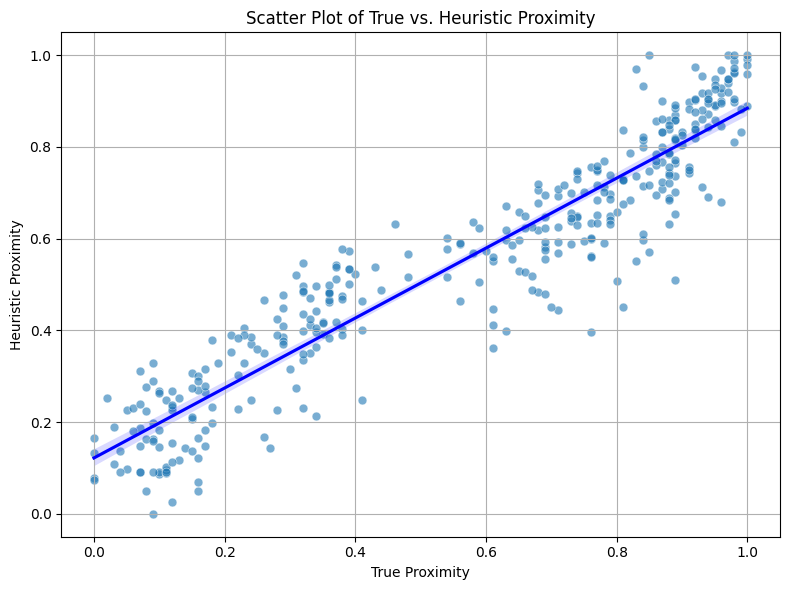

In [18]:
# Combined metrics
calculate_metrics(proximity_eval_df_clean, "Combined", "clara")

# Metrics for adults
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'adult'], "Adults", "clara")

# Metrics for children
calculate_metrics(proximity_eval_df_clean[proximity_eval_df_clean['age_group'] == 'child'], "Children", "clara")
# Visualize with regression line and color by age group
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='proximity_true_clara',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    alpha=0.6,  # Transparency for points
    s=40  # Size of points
)

# Add regression lines for each group
sns.regplot(
    x='proximity_true_clara',
    y='proximity_heuristic',
    data=proximity_eval_df_clean,
    scatter=False,
    color='blue',
    label='Regression Line'
)

# Add plot labels and legend
plt.title('Scatter Plot of True vs. Heuristic Proximity')
plt.xlabel('True Proximity')
plt.ylabel('Heuristic Proximity')
plt.grid(True)
plt.tight_layout()
plt.show()

## Query random samples and store them

In [ ]:
def get_balanced_face_samples():
    import sqlite3
    import pandas as pd
    from pathlib import Path
    from datetime import datetime
    import logging

    conn = sqlite3.connect('/home/nele_pauline_suffo/outputs/detection_pipeline_results/detection_results.db')
    df = pd.read_sql_query("""
    WITH RankedFaces AS (
        SELECT 
            v.video_id,
            v.video_path,
            d.frame_number,
            d.confidence_score,
            d.proximity,
            d.object_class,
            d.x_min,
            d.y_min, 
            d.x_max,
            d.y_max,
            CAST(d.proximity * 10 AS INTEGER) AS proximity_bin
        FROM Detections d
        JOIN Videos v ON d.video_id = v.video_id
        WHERE d.object_class IN (2, 3)
            AND d.proximity BETWEEN 0 AND 1
    ),
    PerVideoSamples AS (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY 
                    object_class,
                    proximity_bin,
                    video_id
                ORDER BY RANDOM()
            ) AS rn_per_video
        FROM RankedFaces
    ),
    DiverseSamples AS (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY object_class, proximity_bin
                ORDER BY RANDOM()
            ) AS rn_total
        FROM PerVideoSamples
        WHERE rn_per_video = 1  -- Only one sample per video per bin per class
    )
    SELECT 
        '/home/nele_pauline_suffo/ProcessedData/quantex_videos_processed/' || video_path || '/' || 
        video_path || '_' || printf('%06d', frame_number) || '.jpg' AS frame_file_name,
        video_id,
        confidence_score,
        proximity,
        proximity_bin,
        x_min,
        y_min,
        x_max,
        y_max,
        CASE 
            WHEN object_class = 3 THEN 'adult' 
            WHEN object_class = 2 THEN 'child' 
        END AS age_group,
        CAST(proximity_bin/10.0 AS TEXT) || '-' || CAST((proximity_bin + 1)/10.0 AS TEXT) AS proximity_range
    FROM DiverseSamples
    WHERE rn_total <= 10  -- Get max 10 per bin per class
    ORDER BY age_group, proximity_bin, video_id;
    """, conn)
    
    # Log summary statistics
    summary_df = df.groupby(['age_group', 'proximity_range']).agg({
        'frame_file_name': 'count'
    }).reset_index()
    summary_df.columns = ['Age Group', 'Proximity Range', 'Total Samples']
    
    logging.info("\nSummary per bin:")
    logging.info(summary_df.to_string())
    
    # Save to CSV with bounding box information
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = Path(f"/home/nele_pauline_suffo/outputs/proximity_sampled_frames/proximity_samples_{current_time}.csv")
    output_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_path, index=False)
    
    conn.close()
    return df

def copy_face_samples(df):
    # First verify we have data
    if df.empty:
        logging.error("DataFrame is empty - no samples to copy")
        return
        
    logging.info(f"Processing {len(df)} samples")
    logging.info(f"Distribution:\n{df.groupby('age_group').size()}")
    
    # Define output directories
    base_dir = Path('/home/nele_pauline_suffo/outputs/proximity_sampled_frames')
    adult_dir = base_dir / 'adult_faces'
    child_dir = base_dir / 'child_faces'
    
    # Create directories if they don't exist
    adult_dir.mkdir(parents=True, exist_ok=True)
    child_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy files for each age group
    copied_count = {'adult': 0, 'child': 0}
    error_count = {'adult': 0, 'child': 0}
    
    # Define colors for bounding boxes (BGR format)
    colors = {
        'adult': (0, 255, 0),  # Green for adult
        'child': (0, 0, 255)   # Red for child
    }
    
    # Create random orders for each age group
    for age_group in ['adult', 'child']:
        age_df = df[df['age_group'] == age_group].copy()
        # Create random order indices
        random_indices = np.random.permutation(len(age_df))
        age_df['random_prefix'] = [f"{i:03d}" for i in random_indices]
        
        target_dir = adult_dir if age_group == 'adult' else child_dir
        
        for _, row in age_df.iterrows():
            src_path = Path(row['frame_file_name'])
            
            if not src_path.exists():
                logging.warning(f"Source file not found: {src_path}")
                error_count[age_group] += 1
                continue
                
            try:
                # Read the image
                img = cv2.imread(str(src_path))
                if img is None:
                    logging.error(f"Could not read image: {src_path}")
                    error_count[age_group] += 1
                    continue
                    
                # Draw bounding box
                x1, y1, x2, y2 = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])
                cv2.rectangle(img, (x1, y1), (x2, y2), colors[age_group], 2)
                
                # Create new filename with random prefix and proximity
                new_filename = f"{row['random_prefix']}_{src_path.name}"
                dst_path = target_dir / new_filename
                
                # Save the image with bounding box
                cv2.imwrite(str(dst_path), img)
                
                copied_count[age_group] += 1
                if copied_count[age_group] % 10 == 0:
                    logging.info(f"Copied {copied_count[age_group]} {age_group} face images")
                    
            except Exception as e:
                logging.error(f"Error processing {src_path}: {e}")
                error_count[age_group] += 1

    # Log final statistics
    for age_group in ['adult', 'child']:
        logging.info(f"{age_group.title()} faces - Copied: {copied_count[age_group]}, "
                    f"Errors: {error_count[age_group]}")
    
def create_empty_proximity_xlsx(df):
    """Create a single Excel file with separate sheets for adult and child faces.
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the face samples data
    """
    import pandas as pd
    from pathlib import Path
    import logging

    base_dir = Path('/home/nele_pauline_suffo/outputs/proximity_sampled_frames')
    output_path = base_dir / 'proximity_samples_fill_in.xlsx'
    
    # Create Excel writer object
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Process each age group
        for age_group in ['adult', 'child']:
            folder_path = base_dir / f'{age_group}_faces'
            
            if not folder_path.exists():
                logging.error(f"Folder not found: {folder_path}")
                continue
                
            # Get all jpg files from the folder
            frame_files = sorted(folder_path.glob('*.jpg'))
            
            # Create DataFrame with filenames and empty proximity column
            output_df = pd.DataFrame({
                'frame_file_name': [f.name for f in frame_files],
                'proximity': ''  # empty column for manual proximity values
            })
            
            # Write to specific sheet in Excel file
            sheet_name = 'Adult Faces' if age_group == 'adult' else 'Child Faces'
            output_df.to_excel(writer, sheet_name=sheet_name, index=False)
            
            logging.info(f"Added {len(output_df)} {age_group} frames to sheet '{sheet_name}'")
    
    logging.info(f"Created Excel file at: {output_path}")

In [7]:
heuristic_df = get_balanced_face_samples()

len(heuristic_df)

2025-04-08 14:14:37,288 - INFO - 
Summary per bin:
2025-04-08 14:14:37,291 - INFO -    Age Group Proximity Range  Total Samples
0      adult         0.0-0.1             10
1      adult         0.1-0.2             10
2      adult         0.2-0.3             10
3      adult         0.3-0.4             10
4      adult         0.4-0.5             10
5      adult         0.5-0.6             10
6      adult         0.6-0.7             10
7      adult         0.7-0.8             10
8      adult         0.8-0.9             10
9      adult         0.9-1.0             10
10     adult         1.0-1.1             10
11     child         0.0-0.1             10
12     child         0.1-0.2             10
13     child         0.2-0.3             10
14     child         0.3-0.4             10
15     child         0.4-0.5             10
16     child         0.5-0.6             10
17     child         0.6-0.7             10
18     child         0.7-0.8             10
19     child         0.8-0.9        

220

In [10]:
# copy face samples to output directory
copy_face_samples(heuristic_df)

2025-04-08 14:22:59,921 - INFO - Processing 220 samples
2025-04-08 14:22:59,925 - INFO - Distribution:
age_group
adult    110
child    110
dtype: int64
2025-04-08 14:23:00,741 - INFO - Copied 10 adult face images
2025-04-08 14:23:10,831 - INFO - Copied 20 adult face images
2025-04-08 14:23:12,366 - INFO - Copied 30 adult face images
2025-04-08 14:23:13,231 - INFO - Copied 40 adult face images
2025-04-08 14:23:14,102 - INFO - Copied 50 adult face images
2025-04-08 14:23:14,852 - INFO - Copied 60 adult face images
2025-04-08 14:23:15,647 - INFO - Copied 70 adult face images
2025-04-08 14:23:16,631 - INFO - Copied 80 adult face images
2025-04-08 14:23:17,409 - INFO - Copied 90 adult face images
2025-04-08 14:23:18,213 - INFO - Copied 100 adult face images
2025-04-08 14:23:19,102 - INFO - Copied 110 adult face images
2025-04-08 14:23:19,862 - INFO - Copied 10 child face images
2025-04-08 14:23:20,748 - INFO - Copied 20 child face images
2025-04-08 14:23:21,588 - INFO - Copied 30 child face

In [11]:
# create empty proximity CSV for manual input
create_empty_proximity_xlsx(heuristic_df)

2025-04-08 14:27:19,893 - INFO - Added 110 adult frames to sheet 'Adult Faces'
2025-04-08 14:27:19,899 - INFO - Added 110 child frames to sheet 'Child Faces'
2025-04-08 14:27:19,916 - INFO - Created Excel file at: /home/nele_pauline_suffo/outputs/proximity_sampled_frames/proximity_samples_fill_in.xlsx
